In [2]:
from fusion_model import CombinedModel

import torch
from MRIdata import MRIdataset
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

%reload_ext autoreload
%autoreload 2

dataPath = 'E:/data/CLAHE_data_st_yz_xah/tumor+1cm/external_test_yz2024_duke/'
#trainDataset = MRIdataset(dataPath, 'train')
dukeDataset = MRIdataset(dataPath, 'test_duke')
yz2024Dataset = MRIdataset(dataPath, 'test_yz2024')

In [3]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler
import copy

# 修改后的 test 函数，增加准确率输出并保存预测结果
def test(model, dataset, dataset_name):
    y_pred = []
    y_true = []
    y_score = []
    patient_ids = []  # 用于存储患者ID

    dataset.prepared = False
    model.eval()
    for d in DataLoader(dataset, batch_size=5):
        inputs = d['image'].cuda()
        inputs2 = d['margin'].cuda()
        labels = d['label'].cuda()
        IDs = d['ID']

        outputs = model(inputs, inputs2)
        outputs = outputs.detach()

        y_pred += torch.argmax(outputs, 1).tolist()
        y_true += labels.tolist()
        y_score += F.softmax(outputs, dim=1)[:, 1].tolist()
        patient_ids += IDs  # 添加患者ID到列表

    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    y_score = torch.tensor(y_score)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_true, y_pred)

    # 保存预测结果
    results_df = pd.DataFrame({
        'ID':patient_ids,
        'True_Label': y_true.tolist(),
        'Predicted_Label': y_pred.tolist(),
        'Predicted_Score': y_score.tolist()
    })
    results_df.to_csv(f'{dataset_name}_predictions.csv', index=False)

    return auc_score, accuracy, confusion_matrix(y_true, y_pred, normalize='true'), fpr, tpr

In [4]:
bestmodel = torch.load('20250310models_new/bestRES_1.502_acc0.745_auc0.80/bestRES_1.502_acc0.745.pt', weights_only=False)#best_1.437_auc0.782/bestRES_1.437
v_auc, v_acc, v_cm, v_fpr, v_tpr = test(bestmodel, yz2024Dataset, 'val')
te_auc, te_acc, te_cm, te_fpr, te_tpr = test(bestmodel, dukeDataset, 'test')

print(
	f'val {v_auc:.3f} [{v_cm[0,0]:.3f} {v_cm[1,1]:.3f}]',
	f'test {te_auc:.3f} [{te_cm[0,0]:.3f} {te_cm[1,1]:.3f}]',
)
print(f'val {v_acc:.3f} ',f'test {te_acc:.3f} ')
#torch.save(bestmodel, 'bestRES_1.370_0.777.pt')

val 0.610 [0.633 0.571] test 0.772 [0.420 1.000]
val 0.627  test 0.421 


In [5]:
def plot_roc_curve(fpr, tpr,dataset_name, color='deeppink'):
    plt.plot(fpr, tpr, color=color, label=f'{dataset_name} (AUC = {auc(fpr, tpr):.3f})')


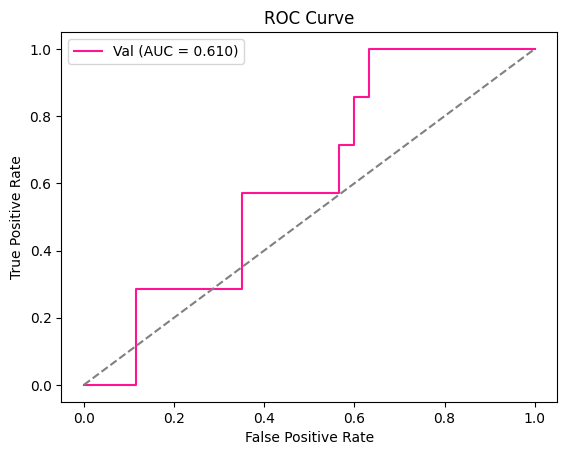

In [6]:
# 绘制 ROC 曲线
plt.figure()
plot_roc_curve(v_fpr, v_tpr, 'Val')
# 添加对角线（虚线）
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('roc_curve_val.png')
plt.show()

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

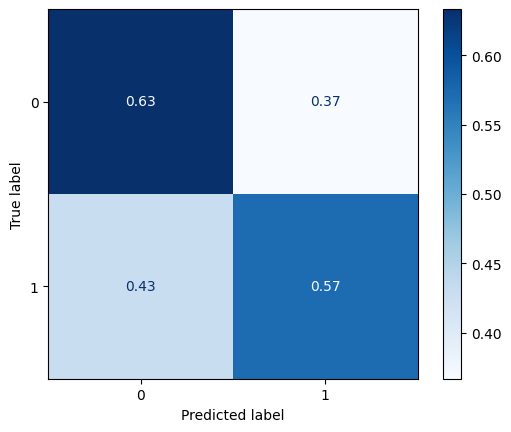

In [8]:
#plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=v_cm)
disp.plot(cmap='Blues')
plt.savefig('cm_val.png')
plt.show()